# Twitter Sentiment Analysis - POC
---

## Random Forests 2 with Tfidf

- Random Forests with BoW: $78.5\%$

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_Tfidf_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_transformed, 
                                                      y_array, 
                                                      test_size=0.2, 
                                                      random_state=42)

### Define functions

These are helper functions for getting data for plotting the learning curves.

In [4]:
def plot_learning_curve(xs, train_acc, valid_acc):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, X_train.shape[0], 0.4, 0.8])
    plt.plot(xs, train_acc, 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, valid_acc, 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation"]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

### Random Forest 1

This is a small forest of 300 trees which uses `max_features="sqrt"` as a limiting factor.

In [5]:
rf_clf = RandomForestClassifier(n_estimators=300,
                                 max_samples=None, 
                                 max_features="sqrt",
                                 max_depth=None,
                                 random_state=42,
                                 n_jobs=-1, 
                                 verbose=0)

In [6]:
xs, train_acc, valid_acc, loop_ix = [], [], [], 0
for m_instances in range(1000, 101000, 5500):
    loop_ix += 1
    start_loop = time.time()
    rf_clf.fit(X_train[:m_instances], y_train[:m_instances])
    y_train_predict = rf_clf.predict(X_train[:m_instances])
    y_valid_predict = rf_clf.predict(X_valid)
    train_acc.append(accuracy_score(y_train[:m_instances], y_train_predict))
    valid_acc.append(accuracy_score(y_valid, y_valid_predict))
    xs.append(str(m_instances))
    mins, secs = divmod(time.time() - start_loop, 60)
    print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances trained | elapsed {mins:0.0f}m {secs:0.0f}s')

Loop 1 | 1000 instances trained | elapsed 0m 7s
Loop 2 | 6500 instances trained | elapsed 0m 27s
Loop 3 | 12000 instances trained | elapsed 0m 40s
Loop 4 | 17500 instances trained | elapsed 1m 4s
Loop 5 | 23000 instances trained | elapsed 1m 25s
Loop 6 | 28500 instances trained | elapsed 1m 50s
Loop 7 | 34000 instances trained | elapsed 2m 15s
Loop 8 | 39500 instances trained | elapsed 2m 41s
Loop 9 | 45000 instances trained | elapsed 3m 8s
Loop 10 | 50500 instances trained | elapsed 3m 40s
Loop 11 | 56000 instances trained | elapsed 4m 10s
Loop 12 | 61500 instances trained | elapsed 4m 39s
Loop 13 | 67000 instances trained | elapsed 5m 12s
Loop 14 | 72500 instances trained | elapsed 5m 47s
Loop 15 | 78000 instances trained | elapsed 6m 21s
Loop 16 | 83500 instances trained | elapsed 7m 2s
Loop 17 | 89000 instances trained | elapsed 7m 40s
Loop 18 | 94500 instances trained | elapsed 8m 19s
Loop 19 | 100000 instances trained | elapsed 9m 3s


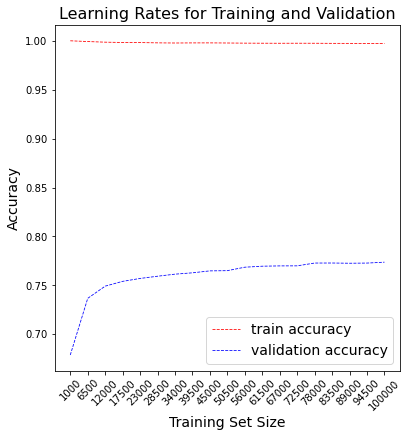

In [7]:
plot_learning_curve(xs, train_acc, valid_acc)

In [8]:
print(f'Min training accuracy: {min(train_acc):0.4f}')
print(f'Max validation accuracy: {max(valid_acc):0.4f}')

Min training accuracy: 0.9973
Max validation accuracy: 0.7737


### Random Forest 2

This is a 1,000-tree forest that uses `max_features=200` as its limiting factor.

In [9]:
rf_clf2 = RandomForestClassifier(n_estimators=1000, # the grid search params
                                 max_samples=None, # 8000 was the max then, got 75% accuracy as well
                                 max_features=200, 
                                 max_depth=None,
                                 random_state=42,
                                 n_jobs=-1, 
                                 verbose=0)

In [10]:
xs, train_acc2, valid_acc2, loop_ix = [], [], [], 0
for m_instances in range(5000, 125000, 25000):
    loop_ix += 1
    start_loop = time.time()
    rf_clf2.fit(X_train[:m_instances], y_train[:m_instances])
    y_train_predict = rf_clf2.predict(X_train[:m_instances])
    y_valid_predict = rf_clf2.predict(X_valid)
    train_acc2.append(accuracy_score(y_train[:m_instances], y_train_predict))
    valid_acc2.append(accuracy_score(y_valid, y_valid_predict))
    xs.append(str(m_instances))
    mins, secs = divmod(time.time() - start_loop, 60)
    print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances trained | elapsed {mins:0.0f}m {secs:0.0f}s')

Loop 1 | 5000 instances trained | elapsed 0m 60s
Loop 2 | 30000 instances trained | elapsed 6m 31s
Loop 3 | 55000 instances trained | elapsed 13m 45s
Loop 4 | 80000 instances trained | elapsed 21m 60s
Loop 5 | 105000 instances trained | elapsed 32m 18s


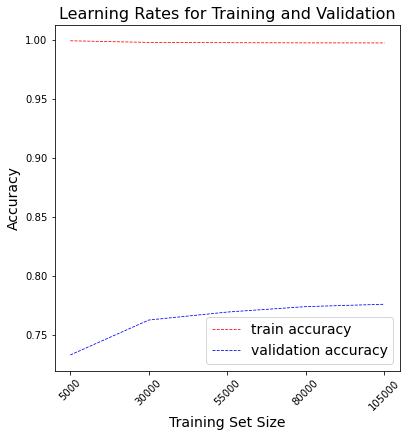

In [11]:
plot_learning_curve(xs, train_acc2, valid_acc2)

In [12]:
print(f'Min training accuracy: {min(train_acc2):0.4f}')
print(f'Max validation accuracy: {max(valid_acc2):0.4f}')

Min training accuracy: 0.9974
Max validation accuracy: 0.7760


### Random Forest 3

This is a large 10,000-tree forest which uses `max_leaf_nodes=99` as its main constraining factor.

In [13]:
rf_clf3 = RandomForestClassifier(n_estimators=10000, 
                                max_samples=None, # 2000 was the max then, got 74.4% accuracy on test set
                                max_features="sqrt", 
                                max_leaf_nodes=99, 
                                random_state=42,
                                n_jobs=-1, 
                                verbose=0)

In [14]:
xs, train_acc3, valid_acc3, loop_ix = [], [], [], 0
for m_instances in range(10000, 170000, 50000):
    loop_ix += 1
    start_loop = time.time()
    rf_clf3.fit(X_train[:m_instances], y_train[:m_instances])
    y_train_predict = rf_clf3.predict(X_train[:m_instances])
    y_valid_predict = rf_clf3.predict(X_valid)
    train_acc3.append(accuracy_score(y_train[:m_instances], y_train_predict))
    valid_acc3.append(accuracy_score(y_valid, y_valid_predict))
    xs.append(str(m_instances))
    mins, secs = divmod(time.time() - start_loop, 60)
    print(f'Loop {loop_ix:0.0f} | {m_instances:0.0f} instances trained | elapsed {mins:0.0f}m {secs:0.0f}s')

Loop 1 | 10000 instances trained | elapsed 2m 45s
Loop 2 | 60000 instances trained | elapsed 16m 39s
Loop 3 | 110000 instances trained | elapsed 32m 47s
Loop 4 | 160000 instances trained | elapsed 49m 46s


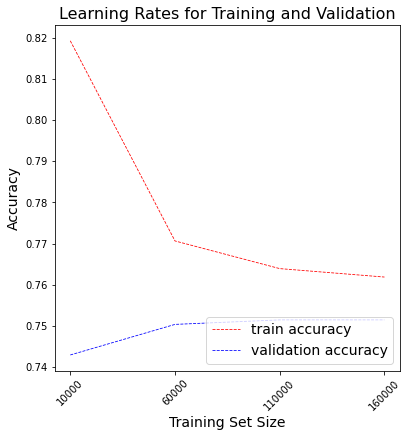

In [15]:
plot_learning_curve(xs, train_acc3, valid_acc3)

In [16]:
print(f'Min training accuracy: {min(train_acc3):0.4f}')
print(f'Max validation accuracy: {max(valid_acc3):0.4f}')

Min training accuracy: 0.7619
Max validation accuracy: 0.7514


### Use entire POC training samples ($m=250k, n\approx224$)

At this point, I think it's a waste of time to pursue the Tfidf and retrain the same model that took 3 hours, I believe it'll get similar or wors accuracy.

---